In [1]:
import addfips
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import numpy as np
import pickle
import random
from matplotlib.patches import Polygon, PathPatch
from matplotlib.collections import PatchCollection
from scipy.stats.stats import pearsonr   

In [2]:
%matplotlib inline

In [3]:
af = addfips.AddFIPS()

In [4]:
df = pd.read_csv('data/gbp_county_wiki.csv')
df = df[np.isfinite(df['Rank'])]
df = df.reset_index()

In [36]:
sLength = len(df)
df['FIPS'] = pd.Series(np.zeros(sLength, dtype=np.int64), 
                       index=df.index)
df['County-equivalent'] = df['County-equivalent'].str.lower()
for i in range(len(df)):
    st_ = df['State'][i]
    county_ = df['County-equivalent'][i]
    if county_ == 'washington city':
        county_ = 'washington'
    elif county_ == 'dewitt' and st_ in ['IL', 'Illinois']:
        county_ = 'de witt'
    elif county_ == 'desoto' and st_ in ['LA', 'Louisiana']:
        county_ = 'de soto'
    df['FIPS'][i] = int(af.get_county_fips(county_, state=st_))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# saving/loading above operation
# pickle.dump(df['FIPS'], open('fips.p', 'wb'))
df['FIPS'] = pickle.load(open('fips.p', 'rb'))

In [38]:
sLength = len(df)
df['total_GDP'] = pd.Series(np.zeros(sLength, dtype=np.int64), index=df.index)
for i in range(len(df)):
    df['total_GDP'][i] = (df['Per-capita-income'][i] * df['Population'][i])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# saving above operation
# pickle.dump(df['total_GDP'], open('total_GDP.p', 'wb'))
df['total_GDP'] = pickle.load(open('total_GDP.p', 'rb'))

In [76]:
gdp = np.copy(df['total_GDP'].values)
gdp.sort()

half_ = sum(gdp)*.5
t_ = 0
for i in range(len(gdp)):
    if t_ < half_:
        t_ += gdp[i]
    else:
        break
print(i, gdp[i])

3027 16006044615


In [77]:
df['GDP_50'] = (df['total_GDP'] > 16006044615)

In [78]:
df

,index,Rank,County-equivalent,State,Per-capita-income,Median-household-income,Median-family-income,Population,Number-of-households,FIPS,total_GDP,GDP_50,GDP_80
0,0,1.0,new york county,New York,62498,69659,84627,1605272,736192,36061,100326289456,True,True
1,1,2.0,arlington,Virginia,62018,103208,139244,214861,94454,51013,13325249498,False,True
2,2,3.0,falls church city,Virginia,59088,120000,152857,12731,5020,51610,752249328,False,False
3,3,4.0,marin,California,56791,90839,117357,254643,102912,6041,14461430613,False,True
4,4,5.0,alexandria city,Virginia,54608,85706,107511,143684,65369,51510,7846295872,False,True
5,5,6.0,pitkin,Colorado,51814,72745,93981,17173,7507,8097,889801822,False,False
6,6,7.0,los alamos,New Mexico,51044,106686,124979,17979,7590,35028,917720076,False,False
7,7,8.0,fairfax county,Virginia,50532,110292,128596,1101071,389908,51059,55639319772,True,True
8,8,9.0,hunterdon,New Jersey,50349,106143,125828,127047,46816,34019,6396689403,False,True
9,9,10.0,borden,Texas,50042,71607,76250,649,225,48033,32477258,False,False


In [11]:
def draw_map_background(m, ax):
    ax.set_axis_bgcolor('#729FCF')
    m.fillcontinents(color='#FAFAFA', ax=ax, zorder=0)
    m.drawcounties(ax=ax)
    m.drawstates(ax=ax,color='#828282')
    m.drawcountries(ax=ax)
    m.drawcoastlines(ax=ax)
    
def USCountyMap(ax=None):
    if ax is None:
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
    
    KM = 1000.
    clat = 39.3
    clon = -94.7333
    wid = 5500 * KM
    hgt = 3500 * KM
    m = Basemap(width=wid,
                height=hgt,
                rsphere=(6378137.00,6356752.3142),
                resolution='i', 
                area_thresh=2500., 
                projection='lcc',
                lat_1=38.5, lat_2=38.5, lat_0=clat, lon_0=clon)
    draw_map_background(m, ax)
    return [fig, ax, m]

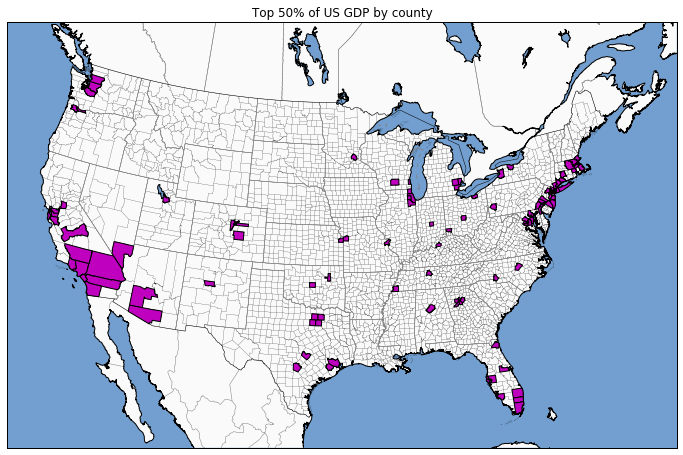

In [89]:
fig, ax, m = USCountyMap()

patches = []
for info, shape in zip(m.counties_info, m.counties):
    tmp = df.loc[df['FIPS'] == int(info['FIPS'])]
    if len(tmp) == 1:
        if tmp['GDP_50'].values[0]:
            patches.append( Polygon(np.array(shape), True) )
ax.add_collection(PatchCollection(patches, 
                                  facecolor= 'm', 
                                  edgecolor='k', 
                                  linewidths=1., 
                                  zorder=2,
                                  alpha=1))

ax.set_title('Top 50% of US GDP by county')

Add election data

In [7]:
df_election = pd.read_csv('data/US_County_Level_Presidential_Results_12-16.csv')

In [8]:
merged = df.merge(df_election,how='left', left_on='FIPS', right_on='FIPS')

In [87]:
merged

,index,Rank,County-equivalent,State,Per-capita-income,Median-household-income,Median-family-income,Population,Number-of-households,FIPS,...,county_name,total_votes_2012,votes_dem_2012,votes_gop_2012,county_fips,state_fips,per_dem_2012,per_gop_2012,diff_2012,per_point_diff_2012
0,0,1.0,new york county,New York,62498,69659,84627,1605272,736192,36061,...,New York County,496293.0,417861.0,72300.0,61.0,36.0,0.841964,0.145680,345561.0,0.696284
1,1,2.0,arlington,Virginia,62018,103208,139244,214861,94454,51013,...,Arlington County,117279.0,81178.0,34433.0,13.0,51.0,0.692178,0.293599,46745.0,0.398579
2,2,3.0,falls church city,Virginia,59088,120000,152857,12731,5020,51610,...,Falls Church city,7244.0,5006.0,2141.0,610.0,51.0,0.691055,0.295555,2865.0,0.395500
3,3,4.0,marin,California,56791,90839,117357,254643,102912,6041,...,Marin County,99286.0,73450.0,23347.0,41.0,6.0,0.739782,0.235149,50103.0,0.504633
4,4,5.0,alexandria city,Virginia,54608,85706,107511,143684,65369,51510,...,Alexandria city,73470.0,52434.0,20205.0,510.0,51.0,0.713679,0.275010,32229.0,0.438669
5,5,6.0,pitkin,Colorado,51814,72745,93981,17173,7507,8097,...,Pitkin County,9779.0,6648.0,2941.0,97.0,8.0,0.679824,0.300746,3707.0,0.379078
6,6,7.0,los alamos,New Mexico,51044,106686,124979,17979,7590,35028,...,Los Alamos County,10654.0,5191.0,4796.0,28.0,35.0,0.487235,0.450160,395.0,0.037075
7,7,8.0,fairfax county,Virginia,50532,110292,128596,1101071,389908,51059,...,Fairfax County,440174.0,260835.0,173786.0,59.0,51.0,0.592572,0.394812,87049.0,0.197760
8,8,9.0,hunterdon,New Jersey,50349,106143,125828,127047,46816,34019,...,Hunterdon County,62821.0,25148.0,36979.0,19.0,34.0,0.400312,0.588641,11831.0,-0.188329
9,9,10.0,borden,Texas,50042,71607,76250,649,225,48033,...,Borden County,362.0,32.0,324.0,33.0,48.0,0.088398,0.895028,292.0,-0.806630


In [91]:
print(merged.columns.values)

['index' 'Rank' 'County-equivalent' 'State' 'Per-capita-income'
 'Median-household-income' 'Median-family-income' 'Population'
 'Number-of-households' 'FIPS' 'total_GDP' 'GDP_50' 'GDP_80' 'Unnamed: 0'
 'combined_fips' 'votes_dem_2016' 'votes_gop_2016' 'total_votes_2016'
 'per_dem_2016' 'per_gop_2016' 'diff_2016' 'per_point_diff_2016'
 'state_abbr' 'county_name' 'total_votes_2012' 'votes_dem_2012'
 'votes_gop_2012' 'county_fips' 'state_fips' 'per_dem_2012' 'per_gop_2012'
 'diff_2012' 'per_point_diff_2012']


In [108]:
county_colors = {}
for i in range(len(merged['FIPS'].values)):
    blue = merged['per_dem_2016'].values[i]
    red = merged['per_gop_2016'].values[i]
    county_colors[merged['FIPS'].values[i]] = (red, 0, blue)

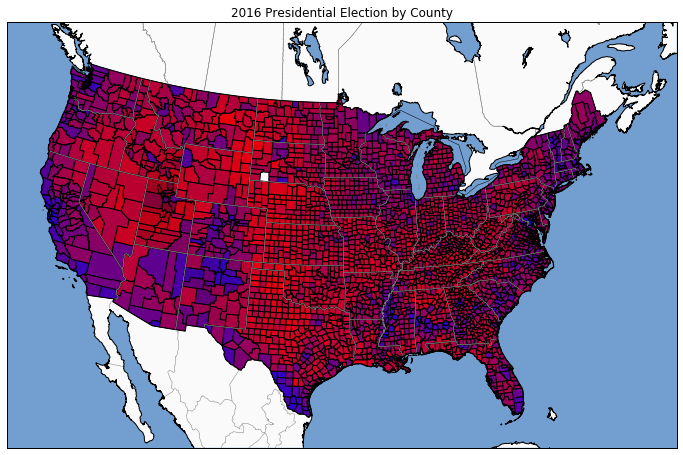

In [137]:
fig, ax, m = USCountyMap()

patches = []
for info, shape in zip(m.counties_info, m.counties):
    tmp = df.loc[df['FIPS'] == int(info['FIPS'])]
    if len(tmp) == 1:
        ccolor = county_colors[int(info['FIPS'])]
        poly = Polygon(np.array(shape), facecolor=ccolor) 
        ax.add_patch(poly)

ax.set_title('2016 Presidential Election by County')

In [120]:
county_colors_12 = {}
for i in range(len(merged['FIPS'].values)):
    blue = merged['per_dem_2012'].values[i]
    red = merged['per_gop_2012'].values[i]
    county_colors_12[merged['FIPS'].values[i]] = (red, 0, blue)

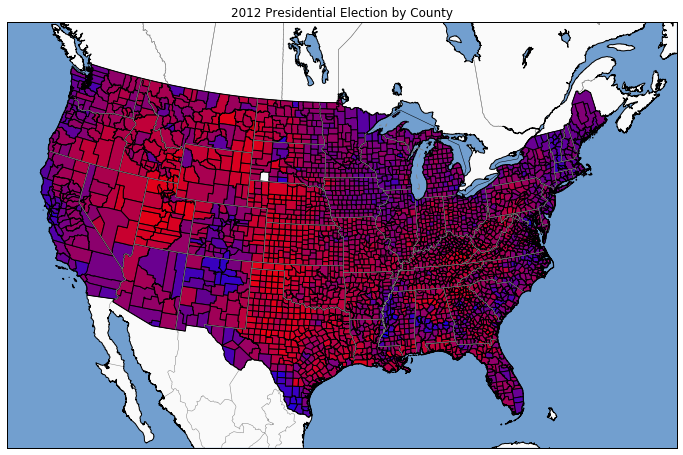

In [138]:
fig, ax, m = USCountyMap()

patches = []
for info, shape in zip(m.counties_info, m.counties):
    tmp = df.loc[df['FIPS'] == int(info['FIPS'])]
    if len(tmp) == 1:
        ccolor = county_colors_12[int(info['FIPS'])]
        poly = Polygon(np.array(shape), facecolor=ccolor) 
        ax.add_patch(poly)

ax.set_title('2012 Presidential Election by County')

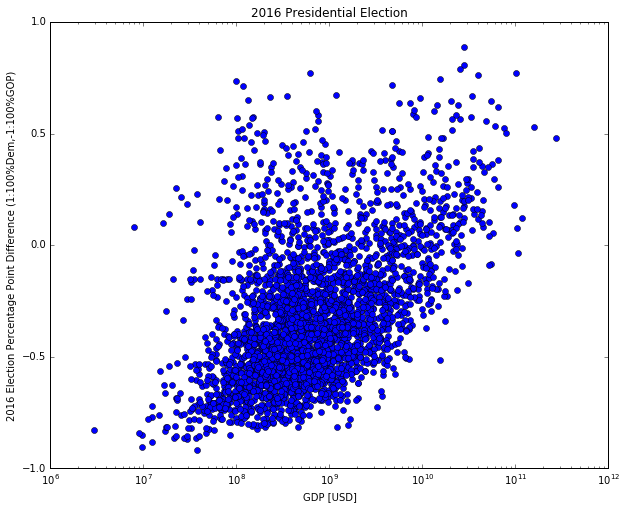

In [9]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

plt.plot(merged['total_GDP'], merged['per_point_diff_2016'], 
         'o')

ax.set_xlabel('GDP [USD]')
ax.set_ylabel('2016 Election Percentage Point Difference ' +\
              '(1:100%Dem,-1:100%GOP)')

plt.semilogx()
ax.set_title('2016 Presidential Election')

In [177]:
a = merged['total_GDP'].values
b = merged['per_point_diff_2016'].values
print(pearsonr(a[(np.isnan(a)==False)&(np.isnan(b)==False)],
               b[(np.isnan(a)==False)&(np.isnan(b)==False)]))

(0.36136853288400039, 1.8655048852970334e-97)


Counties with higher total GDP (predominantly urbun areas) vote more democratic. But the effect is slightly more prominent in the 2016 election (plot above) compared to the 2012 (plot below).

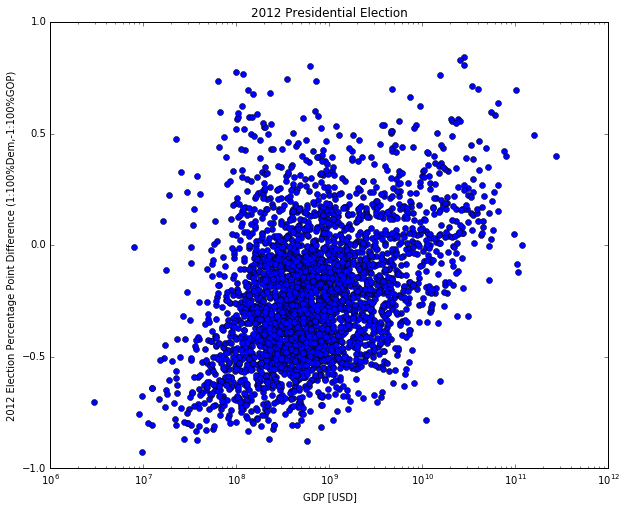

In [10]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

plt.plot(merged['total_GDP'], merged['per_point_diff_2012'], 
         'o')

ax.set_xlabel('GDP [USD]')
ax.set_ylabel('2012 Election Percentage Point Difference ' +\
              '(1:100%Dem,-1:100%GOP)')

plt.semilogx()
ax.set_title('2012 Presidential Election')

In [174]:
a = merged['total_GDP'].values
b = merged['per_point_diff_2012'].values
print(pearsonr(a[(np.isnan(a)==False)&(np.isnan(b)==False)],
               b[(np.isnan(a)==False)&(np.isnan(b)==False)]))

(0.2743570751831636, 7.664751397316927e-55)


In [140]:
off_axis = (merged['total_GDP'] < 1e9) &\
           (merged['per_point_diff_2016'] > 0.0)

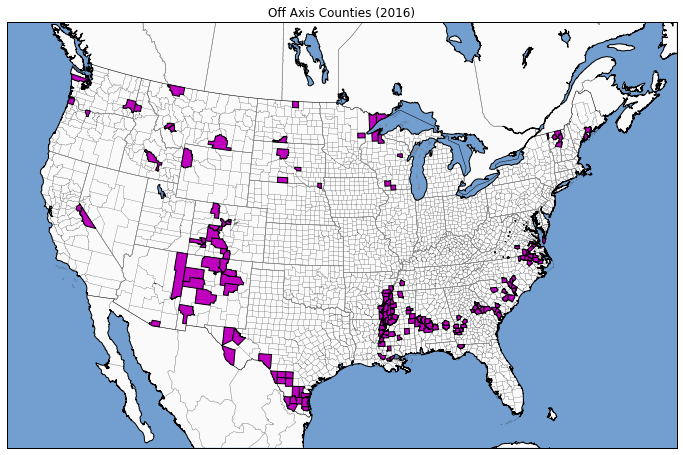

In [153]:
fig, ax, m = USCountyMap()

patches = []
for info, shape in zip(m.counties_info, m.counties):
    tmp = df.loc[df['FIPS'] == int(info['FIPS'])]
    if len(tmp) == 1:
        if off_axis.values[tmp.index[0]]:
            patches.append( Polygon(np.array(shape), True) )
ax.add_collection(PatchCollection(patches, 
                                  facecolor= 'm', 
                                  edgecolor='k', 
                                  linewidths=1., 
                                  zorder=2,
                                  alpha=1))

ax.set_title('Off Axis Counties (2016)')

Off axis counties (democratic with low GDP) are mostly counties with majority black, Hispanic, and native American population.

In [52]:
gdp = np.copy(df['total_GDP'].values)
gdp.sort()

half_ = sum(gdp)*.1
t_ = 0
for i in range(len(gdp)):
    if t_ < half_:
        t_ += gdp[i]
    else:
        break
print(i, gdp[i])

2162 1152564414


In [53]:
merged['GDP_b10'] = (merged['total_GDP'] < 1152564414)

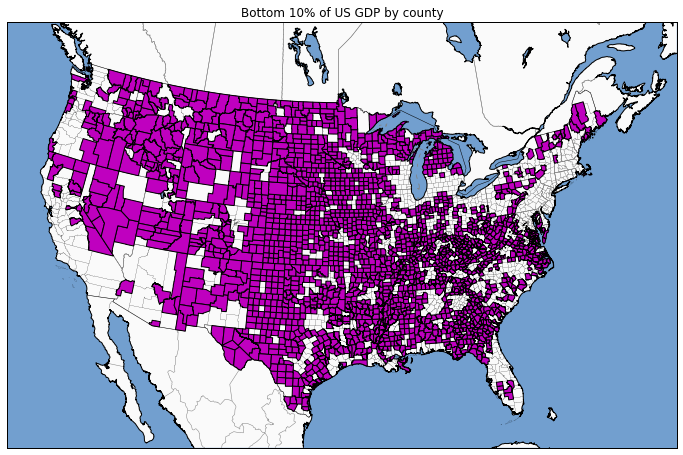

In [54]:
fig, ax, m = USCountyMap()

patches = []
for info, shape in zip(m.counties_info, m.counties):
    tmp = merged.loc[merged['FIPS'] == int(info['FIPS'])]
    if len(tmp) == 1:
        if tmp['GDP_b10'].values[0]:
            patches.append( Polygon(np.array(shape), True) )
ax.add_collection(PatchCollection(patches, 
                                  facecolor= 'm', 
                                  edgecolor='k', 
                                  linewidths=1., 
                                  zorder=2,
                                  alpha=1))

ax.set_title('Bottom 10% of US GDP by county')